# **Atakeen sailkapena konputagailuen arteko komunikazioetan sailkapen gainbegiraturako teknika klasikoak erabiliz**

Beharko ditugun liburutegiak:

In [1]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from typing import List, Tuple
from sklearn import metrics, linear_model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import networkx as nx
from scipy.linalg import fractional_matrix_power
import csv
import os
import math
import random
from sklearn.preprocessing import MinMaxScaler
# Sailkatzaileak inportatzeko
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

## **Datuak kargatzeko**

Erabili diren datuak drive-n gorde dira, eta beraz, bertatik kargatuko dira.

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


## **CSV-ak irakurri eta bakar batean elkartu**

BETH datu-multzoa CSV desberdinetan banatuta dago. Beraz, taula hauek batean batu behar dira.

In [3]:
path = '/content/drive/MyDrive/GrAL/DATUAK/ELKARTZEKO'
files = [os.path.join(path, file) for file in os.listdir(path)]
taula = pd.concat(map(pd.read_csv, files), ignore_index=True)
originala = pd.concat(map(pd.read_csv, files), ignore_index=True)

##**CSV-a moldatu**

Bi taula desberdin erabiliko dira, taula originala, aldaketarik gabekoa, eta moldatutako taula, honek datuak aurreprozesatuta gordeko ditu.

In [4]:
taula = taula[["processId", "parentProcessId", "userId", "eventId", "argsNum", "returnValue", "evil"]]
originala = originala[["processId", "parentProcessId", "userId", "eventId", "argsNum", "returnValue", "evil"]]

# Preprocessing
taula["processId"] = taula["processId"].map(lambda x: 1 if x in [0, 1, 2] else 0)
taula["parentProcessId"] = taula["parentProcessId"].map(lambda x: 1 if x in [0, 1, 2] else 0)
taula["userId"] = taula["userId"].map(lambda x: 1 if x < 1000 else 0)
taula["eventId"] = taula["eventId"]
taula["argsNum"] = taula["argsNum"]
taula["returnValue"] = taula["returnValue"].map(lambda x: 0 if x == 0 else (1 if x > 0 else 2))

# CSV berriak sortu
taula.to_csv('dataset.csv')
originala.to_csv('orig_dataset.csv')

## **Sailkapenak egiteko erabiliko diren ezaugarrien zerrenda prestatzeko**

Lehendabizi, aurretik prestatutako taula berriak irakurriko dira.

In [5]:
# Aurre-prozesatua
with open('/content/dataset.csv',newline='') as f:
    r = csv.reader(f)
    data = [line for line in r]

# Originala
with open('/content/orig_dataset.csv',newline='') as f:
    r2 = csv.reader(f)
    data_orig = [line for line in r2]

Ondoren, ezaugarrien zerrenda prestatuko da.

In [6]:
# EZAUGARRIEN ZERRENDA
max = 9000
kop = 0
nodoak = []
ezaugarriak = []
ertzak = []
unekoGur = ""
unekoUm = ""
ertzaGehitu = True

for i in range(1, len(data_orig)):

  ertzaGehitu = True

  # PROZESU GURASOA
  # Ez bada prozesu gurasoaren identifikatzailea nodoak zerrendan txertatu
  if not int(data_orig[i][2]) in nodoak:
    nodoak.append(int(data_orig[i][2]))
    ezaugarriak.append([-1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, 0.0, kop])   # "-inf"-ekin erabili ostian, erroreak NaN delako infinito, visualize egitean erroreak.
    unekoGur = kop
    kop = kop+1
  else:     # Prozesu gurasoaren identifikatzailea nodoak zerrendan badago
    ind = nodoak.index(int(data_orig[i][2]))
    unekoGur = ezaugarriak[ind][7]

  # PROZESU UMEA
  # Dagoeneko existitzen bada prozesu umea nodoak zerrendan
  if int(data_orig[i][1]) in nodoak:
    ind = nodoak.index(int(data_orig[i][1]))

    if (ezaugarriak[ind][1]==-1000.0):      # Nodoak ez du ezaugarririk prozesu gurasoa izan delako. Ezaugarriak eguneratu beharko dira.
      unekoUm = ezaugarriak[ind][7]
      ezaugarriak[ind][0] = float(data[i][1])
      ezaugarriak[ind][1] = float(data[i][2])
      ezaugarriak[ind][2] = float(data[i][3])
      ezaugarriak[ind][3] = float(data[i][4])
      ezaugarriak[ind][4] = float(data[i][5])
      ezaugarriak[ind][5] = float(data[i][6])
      ezaugarriak[ind][6] = float(data[i][7])
    else:
      if (float(data[i][7]) == 1):          # Prozesua erasotzailea da
        nodoak.append(kop)
        ezaugarriak.append([float(data[i][1]), float(data[i][2]), float(data[i][3]), float(data[i][4]), float(data[i][5]), float(data[i][6]), float(data[i][7]), kop])
        unekoUm = kop
        # Ausazko ertzak sortzeko
        zenbat = random.randint(0, 10)
        for i in range(0, zenbat):
          zein = random.randint(0, 19031-1)
          if (random.randint(0,1) == 0):
            ertzak.append([unekoUm, zein])
          else:
            ertzak.append([zein, unekoUm])
        kop = kop+1

      else:           # Prozesua ez da erasotzailea
        if max>0:
          nodoak.append(kop)
          ezaugarriak.append([float(data[i][1]), float(data[i][2]), float(data[i][3]), float(data[i][4]), float(data[i][5]), float(data[i][6]), float(data[i][7]), kop])
          unekoUm = kop
          max = max-1
          # Ausazko ertzak sortzeko
          zenbat = random.randint(0, 10)
          for i in range(0, zenbat):
            zein = random.randint(0, 19031-1)
            if (random.randint(0,1) == 0):
              ertzak.append([unekoUm, zein])
            else:
              ertzak.append([zein, unekoUm])
          kop = kop+1
        else:
          ertzaGehitu = False

  else:
    nodoak.append(int(data_orig[i][1]))
    ezaugarriak.append([float(data[i][1]), float(data[i][2]), float(data[i][3]), float(data[i][4]), float(data[i][5]), float(data[i][6]), float(data[i][7]), kop])
    unekoUm = kop
    kop = kop+1


  if ertzaGehitu:
    ertzak.append([unekoGur, unekoUm])


_________________________________________________________________________________________________________

# **Ezaugarri hauek estandarizatzeko**

Ezaugarrien balioen arteko desberdintasuna hain handia izanik, balio hauek estandarizatu behar dira. Kasu honetan, Scikit-learn liburutegiak eskaintzen duen MinMaxScaler funtzioa erabili da.

In [7]:
scaler = MinMaxScaler()

In [8]:
x = []
for i in range(0,len(ezaugarriak)):
  x.append([ezaugarriak[i][0], ezaugarriak[i][1], ezaugarriak[i][2], ezaugarriak[i][3], ezaugarriak[i][4], ezaugarriak[i][5]])

In [9]:
new_x = scaler.fit_transform(x)
x = torch.tensor(new_x, dtype=torch.float)
x.size()

torch.Size([19032, 6])

#### **Ezaugarrien etiketak prestatzeko**

Behin ezaugarriak prest izanda, hauen etiketak lortu behar dira, erasotzaileak diren edo ez adierazten dutenak.

In [10]:
y = []
for i in range(0,len(ezaugarriak)):
  y.append(int(ezaugarriak[i][6]))

In [11]:
y = torch.tensor(y)
print("y: ", y)

y:  tensor([0, 0, 0,  ..., 1, 1, 1])


In [12]:
# Zenbat nodo erasotzaile dauden guztira eta indizeak
kont = 0
indizeak = []
for k in range(0, len(y)):
  if (y[k]==1):
    indizeak.append(k)
    kont = kont+1

print("Kopurua: ", kont)
print("Indizeak: ", indizeak)

Kopurua:  10005
Indizeak:  [9027, 9028, 9029, 9030, 9031, 9032, 9033, 9034, 9035, 9036, 9037, 9038, 9039, 9040, 9041, 9042, 9043, 9044, 9045, 9046, 9047, 9048, 9049, 9050, 9051, 9052, 9053, 9054, 9055, 9056, 9057, 9058, 9059, 9060, 9061, 9062, 9063, 9064, 9065, 9066, 9067, 9068, 9069, 9070, 9071, 9072, 9073, 9074, 9075, 9076, 9077, 9078, 9079, 9080, 9081, 9082, 9083, 9084, 9085, 9086, 9087, 9088, 9089, 9090, 9091, 9092, 9093, 9094, 9095, 9096, 9097, 9098, 9099, 9100, 9101, 9102, 9103, 9104, 9105, 9106, 9107, 9108, 9109, 9110, 9111, 9112, 9113, 9114, 9115, 9116, 9117, 9118, 9119, 9120, 9121, 9122, 9123, 9124, 9125, 9126, 9127, 9128, 9129, 9130, 9131, 9132, 9133, 9134, 9135, 9136, 9137, 9138, 9139, 9140, 9141, 9142, 9143, 9144, 9145, 9146, 9147, 9148, 9149, 9150, 9151, 9152, 9153, 9154, 9155, 9156, 9157, 9158, 9159, 9160, 9161, 9162, 9163, 9164, 9165, 9166, 9167, 9168, 9169, 9170, 9171, 9172, 9173, 9174, 9175, 9176, 9177, 9178, 9179, 9180, 9181, 9182, 9183, 9184, 9185, 9186, 9187, 9188, 

#### **Train eta test multzoen banaketa**

Train eta test multzoen banaketa egiteko, bi maskara erabili dira.

In [13]:
# train_mask lortzeko
# Entrenamendu multzoa zein ezaugarrik osatuko duten adierazteko erabiltzen den matrize bitarra da.
a = np.zeros(4513)
b = np.ones(4513)
c = np.zeros(3100)
d = np.ones(6906)
train_mask = torch.tensor(np.concatenate((a,b,c,d)), dtype=torch.bool)

# test_mask lortzeko
# Proba multzoa zein ezaugarrik osatuko duten adierazteko erabiltzen den matrize bitarra da.
e = np.ones(4513)
f = np.zeros(4513)
g = np.ones(3100)
h = np.zeros(6906)
test_mask = torch.tensor(np.concatenate((e,f,g,h)), dtype=torch.bool)

## **k-NN sailkatzailea**

In [14]:
# Sailkatuko diren datuak prestatzeko.
train_x = x[train_mask]
train_y = y[train_mask]
test_x = x[test_mask]
test_y = y[test_mask]

### **1-NN sailkatzailea**

In [15]:
# Sailkatzailea sortu eta doitu behar da
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(train_x, train_y)

predicted = knn.predict(test_x)

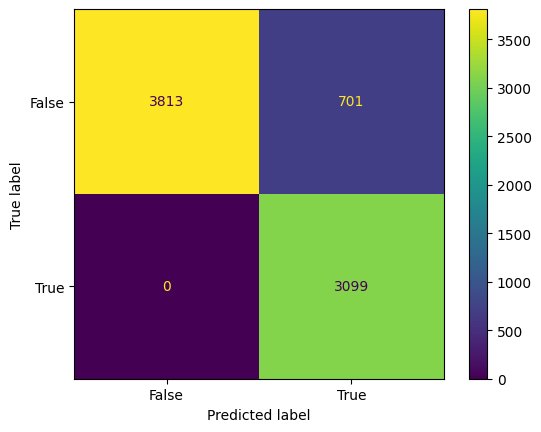

In [16]:
# Lortutako emaitzekin konfusio-matrizea sortu
confusion_matrix = metrics.confusion_matrix(test_y, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [17]:
metrics.precision_score(test_y, predicted, average=None)

array([1.        , 0.81552632])

In [18]:
metrics.recall_score(test_y, predicted, average=None)

array([0.84470536, 1.        ])

In [19]:
metrics.f1_score(test_y, predicted, average=None)

array([0.91581602, 0.89839107])

### **3-NN sailkatzailea**

In [ ]:
# Sailkatuko diren datuak hasieratzeko.
train_x = x[train_mask]
train_y = y[train_mask]
test_x = x[test_mask]
test_y = y[test_mask]

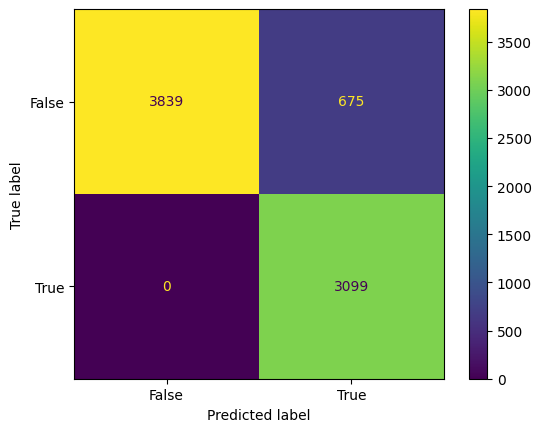

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_x, train_y)

predicted = knn.predict(test_x)

confusion_matrix = metrics.confusion_matrix(test_y, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [ ]:
metrics.precision_score(test_y, predicted, average=None)

array([1.        , 0.82114467])

In [ ]:
metrics.recall_score(test_y, predicted, average=None)

array([0.85046522, 1.        ])

In [ ]:
metrics.f1_score(test_y, predicted, average=None)

array([0.91919071, 0.90178961])

### **5-NN sailkatzailea**

In [ ]:
# Sailkatuko diren datuak hasieratzeko.
train_x = x[train_mask]
train_y = y[train_mask]
test_x = x[test_mask]
test_y = y[test_mask]

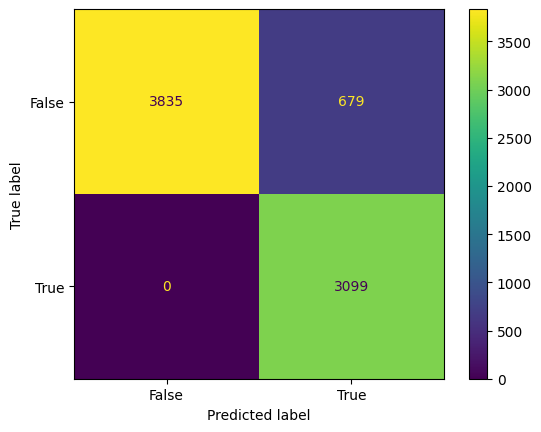

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_x, train_y)

predicted = knn.predict(test_x)

confusion_matrix = metrics.confusion_matrix(test_y, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [ ]:
metrics.precision_score(test_y, predicted, average=None)

array([1.        , 0.82027528])

In [ ]:
metrics.recall_score(test_y, predicted, average=None)

array([0.84957909, 1.        ])

In [ ]:
metrics.f1_score(test_y, predicted, average=None)

array([0.91867289, 0.90126509])

## **Naïve Bayes sailkatzailea**

In [ ]:
# Sailkatuko diren datuak hasieratzeko.
train_x = x[train_mask]
train_y = y[train_mask]
test_x = x[test_mask]
test_y = y[test_mask]

### **Gaussian Naïve Bayes sailkatzailea**

In [ ]:
# Sailkatzailea sortu eta doitu behar da
gnb = GaussianNB()
gnb.fit(train_x, train_y)
predicted = gnb.predict(test_x)

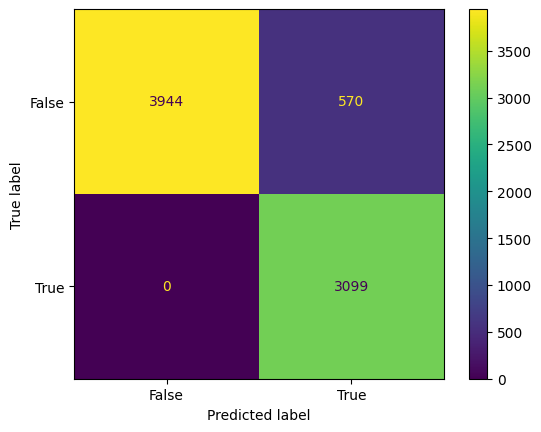

In [ ]:
# Konfusio-matrizea sortzeko
confusion_matrix = metrics.confusion_matrix(test_y, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [ ]:
metrics.precision_score(test_y, predicted, average=None)

array([1.        , 0.84464432])

In [ ]:
metrics.recall_score(test_y, predicted, average=None)

array([0.87372619, 1.        ])

In [ ]:
metrics.f1_score(test_y, predicted, average=None)

array([0.93260818, 0.91578014])